C:\Users\Usuario\AppData\Local\Temp\ipykernel_22196\391697776.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=


Results
   - Accuracy: 94.76%
   - AVG Loss: 0.2360

📊 Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       310
  meningioma       0.91      0.88      0.89       306
     notumor       0.94      0.99      0.96       465
   pituitary       0.96      0.97      0.97       330

    accuracy                           0.95      1411
   macro avg       0.95      0.94      0.94      1411
weighted avg       0.95      0.95      0.95      1411



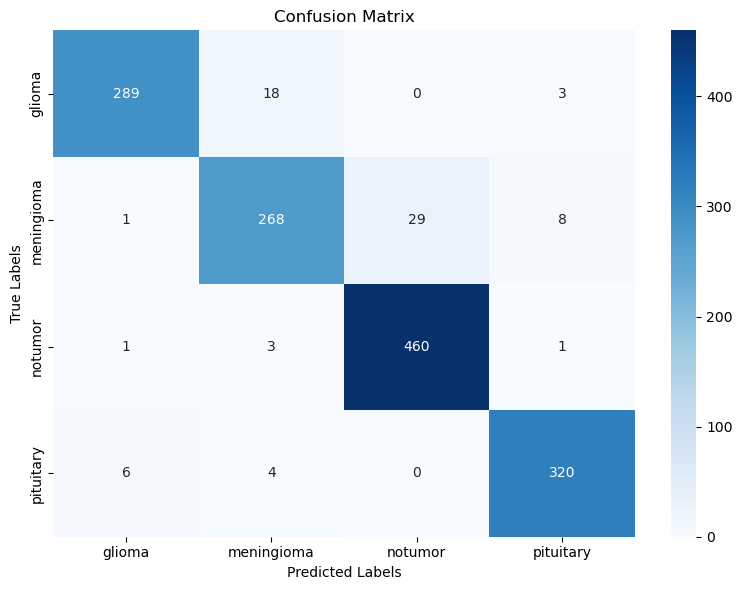

In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from model import Net  

# Configuration
MODEL_PATH = "FL_Models/federated_m1.pth"
TEST_DATA_PATH = "../Data/Testing"
BATCH_SIZE = 32
IMAGE_SIZE = (64, 64)  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = Net(num_classes=4)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Transform for test images
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the test dataset
test_dataset = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate the model
criterion = nn.CrossEntropyLoss()
total_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Results
accuracy = 100 * correct / total
avg_loss = total_loss / len(test_loader)

print("\nResults")
print(f"   - Accuracy: {accuracy:.2f}%")
print(f"   - AVG Loss: {avg_loss:.4f}")
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
